# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). The emails used to build this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). 

In [109]:
from bs4 import BeautifulSoup
from collections import Counter
import email
import joblib
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import re
import string

## 1 Preprocessing

In [170]:
def process_email(txt):
    """
    Takes a text file, opens it, and read in the contents. From there the header of the email is stripped, 
    since we are keeping this program simple. All letters are made lowercase and line breaks removed. HTML 
    is stripped. Numbers, urls, email addresses, and dollar signs are translated into other terms. All 
    other punctuation is stripped. I use a porter stemmer to convert words to their stems and build up the 
    word list that will later be converted to features.
    """
    if (type(txt) == bytes):
        msg_email = email.message_from_bytes(txt)
    else:
        msg_email = email.message_from_string(txt)
    word_list = []
    stemmer = PorterStemmer()
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = re.sub('\n', ' ', msg)
    msg = re.sub('\t', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = re.sub('[0-9]+', 'number', msg)
    msg = re.sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = re.sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = re.sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    msg = msg.translate(table)
    return msg

### 1.1 Load the text files

In [171]:
from sklearn.datasets import load_files

In [172]:
emails = load_files('data/')

In [173]:
emails.target_names

['ham', 'spam']

### 1.2 Split data into train and test sets

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
emails_train, emails_test, y_train, y_test = train_test_split(emails.data, emails.target)

### 1.3 Convert emails to feature vectors

The vocabulary list is used to convert the processed emails into a feature vector. If a vocabulary word is in the email, it is represented as a `1`; otherwise, it is a `0`. 

In [176]:
emails_train[0]

b'From mgm@starlingtech.com  Fri Sep 20 11:29:51 2002\nReturn-Path: <mgm@starlingtech.com>\nDelivered-To: yyyy@localhost.spamassassin.taint.org\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (Postfix) with ESMTP id E7ADD16F03\n\tfor <jm@localhost>; Fri, 20 Sep 2002 11:29:50 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Fri, 20 Sep 2002 11:29:50 +0100 (IST)\nReceived: from host.yrex.com (yrex.com [216.40.247.31]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with SMTP id g8K3gaC19028 for\n    <jm@jmason.org>; Fri, 20 Sep 2002 04:42:42 +0100\nReceived: (qmail 18798 invoked from network); 20 Sep 2002 03:43:04 -0000\nReceived: from mgm.dsl.xmission.com (HELO opus) (204.228.152.186) by\n    yrex.com with SMTP; 20 Sep 2002 03:43:04 -0000\nFrom: "Michael Moncur" <mgm@starlingtech.com>\nTo: "Justin Mason" <yyyy@spamassassin.taint.org>,\n\t"Daniel Quinlan" <quinlan@pathname.com>\nCc: <SpamAssassin

In [177]:
process_email(emails_train[0])

' yes i think some others mgm have spamtrap data in there too   my corpus is about number spamtrap spam at any given time let me know if i should leave that out next time i do keep it separate my spamtraps are pretty clean of viruses and bounce messages most of the time   michael moncur  mgm at starlingtechcom  httpaddr lack of money is no obstacle lack of an idea is an obstacle ken hakuta   '

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

In [179]:
vect = CountVectorizer(max_features=2000, 
                       preprocessor=process_email,
                       decode_error='ignore')
vect.fit(emails_train)
X_train = vect.transform(emails_train)
X_test = vect.transform(emails_test)

In [180]:
X_train[0].toarray()

array([[0, 0, 1, ..., 0, 0, 0]])

## 2 Support Vector Machine

In [189]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

### 2.1 Grid search and cross-validation on train set

In [182]:
tuned_parameters = [{'C': np.logspace(-3,3,7)}]
clf = GridSearchCV(SVC(kernel='linear'), param_grid=tuned_parameters, cv=5, 
                   scoring="f1", return_train_score=True).fit(X_train, y_train)
joblib.dump(clf, 'clf.gz')

['clf.gz']

In [183]:
clf = joblib.load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

### 2.2 Validation curve

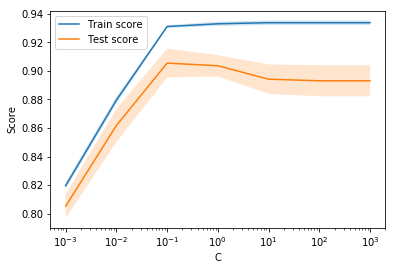

In [184]:
results.plot('param_C', 'mean_train_score', label='Train score')
results.plot('param_C', 'mean_test_score', label='Test score', ax=plt.gca())
plt.fill_between(results.param_C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

### 2.3 Precision-recall curve

In [185]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

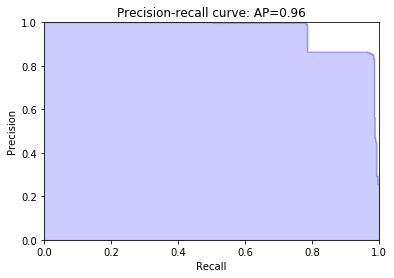

In [186]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

### 2.4 Evaluation of test set

In [187]:
y_true, y_pred = y_test, clf.predict(X_test)

In [190]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.94      0.97      1752
          1       0.85      0.98      0.91       586

avg / total       0.96      0.95      0.95      2338



In [191]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.931


In [192]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.911


### 2.5 Top and bottom predictors of spam

Clearly there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to. `deathtospamdeathtospamdeathtospam` comes from someone's signature. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set.

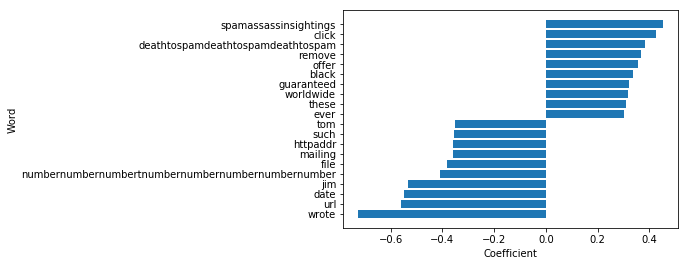

In [204]:
def plot_top_bot(coef, names, n=10):
    coef_argsorted = np.argsort(coef)
    feature_names_array = np.array(names)
    words = []
    values = []
    for i in range(0,n):
        words.append(names[coef_argsorted[i]])
        values.append(coef[coef_argsorted[i]])

    for i in range(-n,0):
        words.append(names[coef_argsorted[i]])
        values.append(coef[coef_argsorted[i]])
    y = np.arange(n*2)
    plt.barh(y, values)
    plt.yticks(y, words)
    plt.xlabel('Coefficient')
    plt.ylabel('Word')
    plt.show()
    
plot_top_bot(clf.best_estimator_.coef_.toarray()[0], vect.get_feature_names())